# Doğrusal Olmayan Regreson Modelleri

In [5]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

from warnings import filterwarnings
filterwarnings('ignore')

# KNN

In [2]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [3]:
knn_model = KNeighborsRegressor().fit(X_train, y_train)

In [4]:
knn_model

KNeighborsRegressor()

In [5]:
#var sayılan komşuluk sayısı
knn_model.n_neighbors

5

In [6]:
knn_model.effective_metric_

'euclidean'

## Tahmin

In [7]:
y_pred = knn_model.predict(X_test)

In [8]:
np.sqrt(mean_squared_error(y_test, y_pred))

426.6570764525201

In [9]:
#farklı k değerlerine göre model farklı değerler oluşturacak. Aşağıda tuning kısmında uygun k değerini bulacağız.
RMSE = [] 

for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred)) 
    RMSE.append(rmse) 
    print("k =" , k , "için RMSE değeri: ", rmse)


k = 1 için RMSE değeri:  0.0
k = 2 için RMSE değeri:  179.52761335480352
k = 3 için RMSE değeri:  205.20157172291863
k = 4 için RMSE değeri:  220.5139794876305
k = 5 için RMSE değeri:  239.6467132541376
k = 6 için RMSE değeri:  243.5904190007242
k = 7 için RMSE değeri:  258.1478781634636
k = 8 için RMSE değeri:  266.05374203349805
k = 9 için RMSE değeri:  269.73782093553376
k = 10 için RMSE değeri:  271.2798300436963


## Model Tuning

### Öncekilerde de gridsearch kullanılabilirdi ancak diğerleri özelleştirilmiş olduğu için gördük.Gridsearch ile hiper parametre arması yapacağız. ızgara mantığıyla olası parametre setinin verilip olası tüm kombinasyonların denenmesi anlamına gelir. İki paramtre verildiğinde bu parametrelerin birbirleriyle çarpıştırılarak olası tüm kombinasyonların denenmesi işleminin cross validation yöntemiyle hesaplanması işlemidir.
#### Bir liste oluşturulacak ve bu liste içerisinde arama işlemi yapılacak

In [10]:
from sklearn.model_selection import GridSearchCV


In [11]:
knn_params = {'n_neighbors': np.arange(1,30,1)}
#knn parametrelerini tanımlarken n_neighbors yazmamızın sebebi algoritmanın içindeki fonksiyonun kabul ettiği parametrenin adıyla aynı isim ile isimlendirmemiz gerekiyor.
#1den 30a kadar k değerlerini oluşturduk ve aşağıda da bu k değerlerini deneyip en iyi hangisini olduğunu göreceğiz.

In [12]:
knn = KNeighborsRegressor()
#Model nesnesini oluşturduk

In [13]:
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10)
#cros validation yöntemini kullanıyorak knn cv nesnesini oluşturuyoruz aşağıda da fit ediyoruz. 1. argümana model nesnesini, 2. argümana denenecek parametreler, 3. argümana kaç katlı cross validation yapmak istediğimizi giriyoruz.

In [14]:
knn_cv_model.fit(X_train, y_train)
#model fit etme işlemi ve kurma işlemi gerçekleşti.

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [15]:
knn_cv_model.best_params_["n_neighbors"]
#en uygun parametreyi bulmak için

8

In [16]:
#train seti üzerinden bir hata hesaplamıştık ancak bunu test train olarak ayırmıştık valide etmemiştik. valide edilmiş ve edilmemiş rmse değerlerini karşılaştırıcaz
RMSE = [] #valide edilmemiş
RMSE_CV = []  #valide edilmiş
for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred)) 
    rmse_cv = np.sqrt(-1*cross_val_score(knn_model, X_train, y_train, cv=10, 
                                         scoring = "neg_mean_squared_error").mean())
    RMSE.append(rmse) 
    RMSE_CV.append(rmse_cv)
    print("k =" , k , "için RMSE değeri: ", rmse, "RMSE_CV değeri: ", rmse_cv )
# aşağıda 1. kısımda test train üzerinden gelen direkt hatalar. 2. kısımda olanlar ise valide edilmiş hatalar.
# görünüşte 2. ksımdaki hataların değeri daha yüksek ancek değişim miktarı daha az bu da onun daha yüksek olmasına rağmen daha güvenilir olduğu anlamına gelir.
# valide edilmiş hataların değer aralığı 18 iken, valide edilmemiş değerlerin aralığı  89.
# burdan da gördüğümüz üzere valide edilmiş değerler üzerinden işlem yapmak daha sağlıklıdır.
# ayrıca yukardaki valide edilmemiş değerlere cross validation işlemi yapıldığında en düşük değer farklı çıkmasına rağmen valide edilmiş değeri biz k=8 almıştık daha güvenilir olduğu için.

k = 1 için RMSE değeri:  0.0 RMSE_CV değeri:  325.3947514706382
k = 2 için RMSE değeri:  179.52761335480352 RMSE_CV değeri:  293.24000183333817
k = 3 için RMSE değeri:  205.20157172291863 RMSE_CV değeri:  283.7486667487823
k = 4 için RMSE değeri:  220.5139794876305 RMSE_CV değeri:  286.3240222024089
k = 5 için RMSE değeri:  239.6467132541376 RMSE_CV değeri:  290.0705466132226
k = 6 için RMSE değeri:  243.5904190007242 RMSE_CV değeri:  298.1263115575851
k = 7 için RMSE değeri:  258.1478781634636 RMSE_CV değeri:  294.77070479194987
k = 8 için RMSE değeri:  266.05374203349805 RMSE_CV değeri:  291.98672028891235
k = 9 için RMSE değeri:  269.73782093553376 RMSE_CV değeri:  295.7162739573105
k = 10 için RMSE değeri:  271.2798300436963 RMSE_CV değeri:  301.31047022701154


In [17]:
# final modelini kuruyoruz optimum parametremiz k=8
knn_tuned = KNeighborsRegressor(n_neighbors = knn_cv_model.best_params_["n_neighbors"])
#tune edilmiş modelin nesnesini oluşturduk aşağıda fit ettik

In [18]:
knn_tuned.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=8)

In [19]:
np.sqrt(mean_squared_error(y_test, knn_tuned.predict(X_test)))
#tune edilmiş final modelinin üzerinden test hatasını elde ettik

413.7094731463598

# SVR (Destek Vektör Regresyonu)

In [20]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [21]:
X_train = pd.DataFrame(X_train["Hits"])
X_test = pd.DataFrame(X_test["Hits"])

In [22]:
from sklearn.svm import SVR

In [23]:
svr_model = SVR("linear").fit(X_train, y_train)

In [24]:
svr_model.predict(X_train)[0:5]

array([403.52804878, 666.91219512, 706.66829268, 194.80853659,
       423.40609756])

In [25]:
print ("y = {0} + {1} x".format(svr_model.intercept_[0], 
                                svr_model.coef_[0][0])) 

y = -48.69756097561513 + 4.969512195122093 x


In [26]:
X_train["Hits"][0:1]
#basit SVR ile tahmin yaptık

183    91.0
Name: Hits, dtype: float64

In [27]:
-48.69756097561513 + 4.969512195122093*91

403.5280487804953

In [28]:
y_pred = svr_model.predict(X_train)

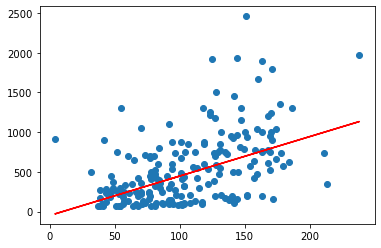

In [29]:
plt.scatter(X_train, y_train)
plt.plot(X_train,y_pred, color = "r")

In [30]:
from sklearn.linear_model import LinearRegression
lm_model = LinearRegression().fit(X_train, y_train)
lm_pred  = lm_model.predict(X_train)
print("y = {0} + {1} x".format(lm_model.intercept_, lm_model.coef_[0])) # {0} formatın 1. değeri, {1} formatın 2. bileşenini yazar. printin farklı kullanımlarından biri. Format ile {} kullanımı.
#linear regression ile tahminde bulunduk

y = -8.814095480334572 + 5.1724561354706875 x


In [31]:
-8.814095480334572 + 5.1724561354706875*91

461.879412847498

Text(0, 0.5, 'Maaş (Salary)')

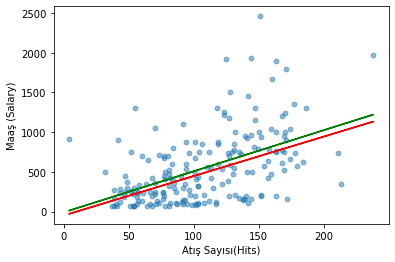

In [32]:
plt.scatter(X_train, y_train, alpha=0.5, s=23)
plt.plot(X_train, lm_pred, 'g')
plt.plot(X_train, y_pred, color='r')

plt.xlabel("Atış Sayısı(Hits)")
plt.ylabel("Maaş (Salary)")
#linear regression ve SVR grafik karşılaştırması nı yaptık. yşil olan linear regression SVR kırmızı olan. Neden böyle çıktı?
#SVR daha robust olduğu için değişmesi daha zordur o yüzden SVR daha aşağıda kaldıç

## Tahmin

In [33]:
print ("y = {0} + {1} x".format(svr_model.intercept_[0], svr_model.coef_[0][0])) 
#svr_model.intercept_ formüldeki y eksenini kesen yer, svr_model.coef_ ise x in önündeki katsayı değeri

y = -48.69756097561513 + 4.969512195122093 x


In [34]:
svr_model.predict([[91]])

array([403.52804878])

In [35]:
y_pred = svr_model.predict(X_test)
#tüm test seti üzerinde uyguluyoruz

In [36]:
np.sqrt(mean_squared_error(y_test, y_pred))
#test hatasını hesapladık(tune edilmemiş model)

459.0187960365147

In [37]:
svr_model

SVR(kernel='linear')

## Model Tuning

In [38]:
svr_model
#ayar parametresi

SVR(kernel='linear')

In [39]:
svr_params = {"C": np.arange(0.1,2,0.1)} #parametre setini ifade eden dizi(0.1'den 2 ye kadar 0.1 artarak para metreleri alacağız) (daha az parametre verirsek daha kısa bir işlem sürer)
svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 10).fit(X_train,y_train) #svr_model üzerinde svr_params parametre değerleri ile 10 katlı cross validation yaptık

In [40]:
pd.Series(svr_cv_model.best_params_)[0]
#en iyi parametre değeri (tek değişkenli değer için yapmıştık zaten 0.1) İlk başta 0.1 çıkmıştı aşağıda veri setini baştan çalıştırdık ve en uygun değeri baştan hesapladık gelen değer ise 0.4
#tüm değişkenler dahil edildiğinde hesaplanan C değeri 0.4 yani. Ki bu da aşağıdaki tahmin değerini değiştirdi.

0.1

In [41]:
pd.Series(svr_cv_model.best_params_)[0]


0.1

In [42]:
svr_tuned = SVR("linear", 
                C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, y_train)
#final modeli oluşturduk. c parametresini hemen yukardan hazır aldık.
#SVR içinde linear kerneli eçtik baştaki "linear" satırı  ile


In [43]:
y_pred = svr_tuned.predict(X_test)
#tahmin değeri oluşturduk. aşağıda test hatamızı hesapladık.

In [44]:
np.sqrt(mean_squared_error(y_test, y_pred))
#test hatasını oluşturduk. Bundan sonasında veri setini tekrar baştan çalıştırıp birden fazla değişken için değer hesaplama işlemini yapacağız.

458.198966781116

In [45]:
np.sqrt(mean_squared_error(y_test, y_pred))
#yukarda ehsapladığımızda sadece hits değişkeni vardı ancak diğer değişkenleri de dahil ettiğimizde diğer değişkenlerin de bağımlı değişkendeki değişkenliği açıklama gücüne sahipmiş (anlamlı bir etkisi varmış) ki 97 birim aşağı geldi değer.
#basit SVRdan daha düşük bir değer elde ettik. Basit SVR'da sadece bir değişkeni dahil etmiştik.

458.198966781116

# Doğrusal Olmayan SVR

#### Linear regresyonu bir öncekinde Doğrusal SVR ile karşılaştırmıştık. Şimdi ise Linear Olmayan SVR ile karşılaştırıyoruz.

In [46]:
np.random.seed(3)
#suni veri seti oluşturduk
x_sim = np.random.uniform(2, 10, 145)
y_sim = np.sin(x_sim) + np.random.normal(0, 0.4, 145)

#aykırı gözlemler ekledik 
x_outliers = np.arange(2.5, 5, 0.5)
y_outliers = -5*np.ones(5)

x_sim_idx = np.argsort(np.concatenate([x_sim, x_outliers]))
x_sim = np.concatenate([x_sim, x_outliers])[x_sim_idx]
y_sim = np.concatenate([y_sim, y_outliers])[x_sim_idx]

In [47]:
#linear regresyon
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(np.sin(x_sim[:, np.newaxis]), y_sim)
ols_pred = ols.predict(np.sin(x_sim[:, np.newaxis]))

#doğrusal olmayan SVR
from sklearn.svm import SVR
eps = 0.1
svr = SVR('rbf', epsilon = eps)
svr.fit(x_sim[:, np.newaxis], y_sim)
svr_pred = svr.predict(x_sim[:, np.newaxis])

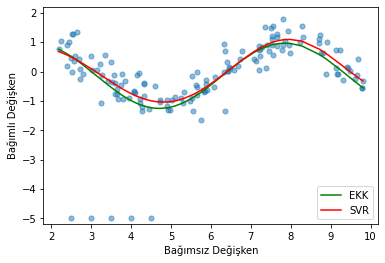

In [48]:
plt.scatter(x_sim, y_sim, alpha=0.5, s=26)
plt_ols, = plt.plot(x_sim, ols_pred, 'g')
plt_svr, = plt.plot(x_sim, svr_pred, color='r')
plt.xlabel("Bağımsız Değişken")
plt.ylabel("Bağımlı Değişken")
plt.ylim(-5.2, 2.2)
plt.legend([plt_ols, plt_svr], ['EKK', 'SVR'], loc = 4);

#eklediğimiz aykırı değerler EKK'yı aşağı doğru çekti SVR daha zor değiştiği güçlü olduğu için çok değişmedi.

In [49]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [50]:
svr_rbf = SVR("rbf").fit(X_train, y_train)
#radial basis function "rbf"
#model kurma işlemini gerçekleştirdik.
#Tüm değişkenleri kullanarak doğrusal olmayan bir model kurduk

## Tahmin

In [51]:
y_pred = svr_rbf.predict(X_test)
#tahmin işlemi. İlkel test hatamızı hesapladık. 

In [52]:
np.sqrt(mean_squared_error(y_test, y_pred))

460.0032657244849

## Model Tuning

In [53]:
svr_rbf

SVR()

In [54]:
svr_params = {"C": [0.01, 0.1,0.4,5,10,20,30,40,50]} # optimize etmemiz gereken bir ceza parametremiz var. içinde deneyeceği değerleri kendimiz parametre seti olarak girdik ki işlem kısa sürsün.
svr_cv_model = GridSearchCV(svr_rbf,svr_params, cv = 10) #svr_rbf modelini kullanarak svr_params içindeki parametrelerin içerisinden 10 karlı cross validation ile bana uygun değeri bulsun
svr_cv_model.fit(X_train, y_train) #fit ettik

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 0.4, 5, 10, 20, 30, 40, 50]})

In [55]:
svr_cv_model.best_params_

{'C': 50}

In [56]:
pd.Series(svr_cv_model.best_params_)[0]
#yuakrda çıkan C değerini almak için pandas serisine çevirim 0. indexi aldığımzda değerini almış ve sonraki işlemde tune edilmiş final modelini oluşturmak için kullanıyoruz.

50

In [57]:
svr_tuned = SVR("rbf", C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, 
                                                                        y_train)
#train set üzerinden tahmin final modelimizi kurduk

In [58]:
y_pred = svr_tuned.predict(X_test)
#x test setinin bağımsız değişkenini bularak y bağımlı değişkeninin değerlerini hesapla.

np.sqrt(mean_squared_error(y_test, y_pred))
#normalde bu kadar yükske çıkmasını beklemezdik ancak veri setinden kaynaklı böyle çıkmış olabilir. KNN'den dkötü çıkmasını beklemezdik.

428.00406888095694

# Çok Katmanlı Algılayıcı

In [59]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [60]:
from sklearn.preprocessing import StandardScaler
#dönüştürme işlemi yapıyoruz. Değişken standardizasyonu.

In [61]:
scaler = StandardScaler()
#scaler fonksiyonunu örnekledik
scaler.fit(X_train)
#dönüştürme işlemini gerçekleştirdik.Aşağıda train ve test seti için de yaptık

StandardScaler()

In [62]:
X_train_scaled = scaler.transform(X_train)

In [63]:
X_test_scaled = scaler.transform(X_test)

In [64]:
from sklearn.neural_network import MLPRegressor

In [65]:
mlp_model = MLPRegressor(hidden_layer_sizes = (100,20)).fit(X_train_scaled, y_train)
#model kurma işlemini yapıyoruz. Multilayer perceptron ile ve sonunda fit ettik

In [66]:
mlp_model

MLPRegressor(hidden_layer_sizes=(100, 20))

In [67]:
mlp_model.n_layers_
#katman sayısına eriştik

4

In [68]:
mlp_model.hidden_layer_sizes
#gizli katman sayısına eriştik.katman sayısının içindeki nöronları ifade eder.

(100, 20)

## Tahmin

In [69]:
mlp_model.predict(X_train_scaled)[0:5]
#kurulan modelde tahmin işlemi

array([ 56.46772652, 261.56912856, 162.47432175,  51.47698931,
        31.07854772])

In [70]:
y_pred = mlp_model.predict(X_test_scaled)
#ilkel test hatamızı hesaplamak için modelimizi oluşturduk ve aşağıda da bunu hesapladık.

In [71]:
np.sqrt(mean_squared_error(y_test, y_pred))

527.4270090447499

## Model Tuning

In [72]:
mlp_model

MLPRegressor(hidden_layer_sizes=(100, 20))

In [73]:
mlp_params = {'alpha': [0.1, 0.01,0.02,0.005],
             'hidden_layer_sizes': [(20,20),(100,50,150),(300,200,150)], #1. 2 katmanlı,2.3 katmanlı 3. 3 katmanlı sinir ağını ifade eder
             'activation': ['relu','logistic']} #aktivasyon fonksiyonunu da parametre seçebiliyoruz. Ön tanımlı oalrak relu tanımlanmış ama 2. olarak logistic yöntemini de seçiyoruz

In [74]:
mlp_cv_model = GridSearchCV(mlp_model, mlp_params, cv = 10)
#modelimizi cross validation işlemine tabi tutuyoruz

In [75]:
mlp_cv_model.fit(X_train_scaled, y_train)
#fit etme işlemini gerçekleştirdik

GridSearchCV(cv=10, estimator=MLPRegressor(hidden_layer_sizes=(100, 20)),
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.1, 0.01, 0.02, 0.005],
                         'hidden_layer_sizes': [(20, 20), (100, 50, 150),
                                                (300, 200, 150)]})

In [76]:
mlp_cv_model.best_params_
#aralarındaki en iyi parametre değerlerini görmek için

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50, 150)}

In [77]:
mlp_tuned = MLPRegressor(alpha = 0.02, hidden_layer_sizes = (100,50,150))
#final modelimizi tune edilmiş şekilde oluşturuyoruz

In [78]:
mlp_tuned.fit(X_train_scaled, y_train)
#tune edilmiş modeli fitliyoruz. Optimum hiperparametreler ile

MLPRegressor(alpha=0.02, hidden_layer_sizes=(100, 50, 150))

In [79]:
y_pred = mlp_tuned.predict(X_test_scaled)
#test seti modelimizi oluşturduk

In [80]:
np.sqrt(mean_squared_error(y_test, y_pred))
#test hatlarımızı hesapladık. Diğerlerinden en düşük test hatamızı elde ettik

361.7773902246188

# CART
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
### **Genellenebilirlik kaygısının olmadığı alanlarda kullanılması uygundur. Aksi taktirde overfitting olabilir. Diğer yöntemleri kullanmak daha mantıklı olacaktır. Bir şirketin tek bir departmanı gibi yerlerde.** 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [81]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [82]:
X_train = pd.DataFrame(X_train["Hits"])
X_test = pd.DataFrame(X_test["Hits"])

In [83]:
cart_model = DecisionTreeRegressor()


In [84]:
?cart_model

Type:        DecisionTreeRegressor
String form: DecisionTreeRegressor()
File:        ~/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py
Docstring:  
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"mse", "friedman_mse", "mae"}, default="mse"
    The function to measure the quality of a split. Supported criteria
    are "mse" for the mean squared error, which is equal to variance
    reduction as feature selection criterion and minimizes the L2 loss
    using the mean of each terminal node, "friedman_mse", which uses mean
    squared error with Friedman's improvement score for potential splits,
    and "mae" for the mean absolute error, which minimizes the L1 loss
    using the median of each terminal node.

    .. versionadded:: 0.18
       Mean Absolute Error (MAE) criterion.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" 

In [85]:
cart_model = DecisionTreeRegressor(min_samples_split = 2)

In [86]:
?cart_model

Type:        DecisionTreeRegressor
String form: DecisionTreeRegressor()
File:        ~/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py
Docstring:  
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"mse", "friedman_mse", "mae"}, default="mse"
    The function to measure the quality of a split. Supported criteria
    are "mse" for the mean squared error, which is equal to variance
    reduction as feature selection criterion and minimizes the L2 loss
    using the mean of each terminal node, "friedman_mse", which uses mean
    squared error with Friedman's improvement score for potential splits,
    and "mae" for the mean absolute error, which minimizes the L1 loss
    using the median of each terminal node.

    .. versionadded:: 0.18
       Mean Absolute Error (MAE) criterion.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" 

In [87]:
cart_model.fit(X_train, y_train)

DecisionTreeRegressor()

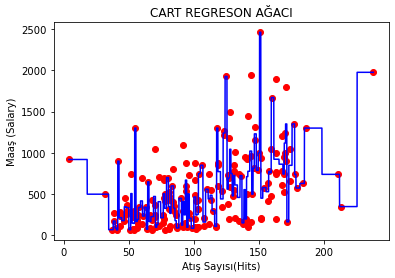

In [88]:
X_grid = np.arange(min(np.array(X_train)),max(np.array(X_train)), 0.01) 
X_grid = X_grid.reshape((len(X_grid), 1)) #görsel anlamda görebilmek adına bir grid oluşturuyoruz(ızgara).
plt.scatter(X_train, y_train, color = 'red') #salary ve hits değişkenleri için scatter plot oluşturduk.
plt.plot(X_grid, cart_model.predict(X_grid), color = 'blue')  #grid yardımıyla tahmin edilen değerleri grafiğe işleme yapıyoruz.
plt.title('CART REGRESON AĞACI')  
plt.xlabel('Atış Sayısı(Hits)') 
plt.ylabel('Maaş (Salary)') ; #isimlendirmeleri yaptık.

In [89]:
cart_model = DecisionTreeRegressor(max_leaf_nodes=3)

In [90]:
cart_model.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=3)

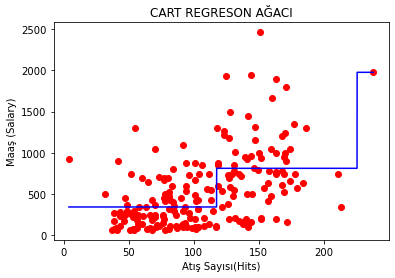

In [91]:
X_grid = np.arange(min(np.array(X_train)),max(np.array(X_train)), 0.01) 
X_grid = X_grid.reshape((len(X_grid), 1)) #görsel anlamda görebilmek adına bir grid oluşturuyoruz(ızgara).
plt.scatter(X_train, y_train, color = 'red') #salary ve hits değişkenleri için scatter plot oluşturduk.
plt.plot(X_grid, cart_model.predict(X_grid), color = 'blue')  #grid yardımıyla tahmin edilen değerleri grafiğe işleme yapıyoruz.
plt.title('CART REGRESON AĞACI')  
plt.xlabel('Atış Sayısı(Hits)') 
plt.ylabel('Maaş (Salary)') ; #isimlendirmeleri yaptık.

# Yukardakinden farklı olarak max_leaf_nodes =3 dedik yani ağaçta max bölünme sayısını belirlemiş olduk. Bu da grafikte 3 kırılma olarak görülüyor.

In [92]:
cart_model = DecisionTreeRegressor(max_leaf_nodes=10)

In [93]:
cart_model.fit(X_train,y_train)

DecisionTreeRegressor(max_leaf_nodes=10)

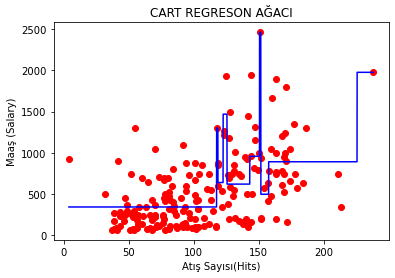

In [94]:
X_grid = np.arange(min(np.array(X_train)),max(np.array(X_train)), 0.01) 
X_grid = X_grid.reshape((len(X_grid), 1)) #görsel anlamda görebilmek adına bir grid oluşturuyoruz(ızgara).
plt.scatter(X_train, y_train, color = 'red') #salary ve hits değişkenleri için scatter plot oluşturduk.
plt.plot(X_grid, cart_model.predict(X_grid), color = 'blue')  #grid yardımıyla tahmin edilen değerleri grafiğe işleme yapıyoruz.
plt.title('CART REGRESON AĞACI')  
plt.xlabel('Atış Sayısı(Hits)') 
plt.ylabel('Maaş (Salary)') ; #isimlendirmeleri yaptık.

# Yukardakinden farklı olarak max_leaf_nodes =10 dedik yani ağaçta max bölünme sayısını belirlemiş olduk. Bu da grafikte 10 kırılma olarak görülüyor.

In [95]:
#!pip install skompiler

In [96]:
!pip install astor

In [97]:
from skompiler import skompile

In [98]:
print(skompile(cart_model.predict).to('python/code'))
#karar ağacının karar modelini elde etmek isterserk de astor uzantısını indirip bu şekilde çevirebiliriz. (Bu karar mekanizmasını başka yerde kullanmak istersek.)
#eğer max_leaf_nodes'i kısa seçersek doğal olarak karar mekanizma formülü de kısa olacak

(345.2011551724138 if x[0] <= 117.5 else ((((1300.0 if x[0] <= 118.5 else 
    641.0) if x[0] <= 122.5 else 1468.5236666666667) if x[0] <= 125.5 else 
    621.9679230769232) if x[0] <= 143.0 else (958.6111111111111 if x[0] <= 
    150.5 else 2460.0) if x[0] <= 151.5 else 499.1666666666667 if x[0] <= 
    157.5 else 892.5402413793104) if x[0] <= 225.5 else 1975.0)



## Tahmin

In [99]:
x = [91]
#yukarda belirtilen DecisionTree modelinin python geliştirme kodunu aşağıdaki gibi yazıp farklı alanlarda kullanabilir implement edebiliriz.

In [100]:
(345.2011551724138 if x[0] <= 117.5 else ((((1300.0 if x[0] <= 118.5 else 
    641.0) if x[0] <= 122.5 else 1468.5236666666667) if x[0] <= 125.5 else 
    621.9679230769232) if x[0] <= 143.0 else (958.6111111111111 if x[0] <= 
    150.5 else 2460.0) if x[0] <= 151.5 else 499.1666666666667 if x[0] <= 
    157.5 else 892.5402413793104) if x[0] <= 225.5 else 1975.0)

345.2011551724138

In [101]:
cart_model.predict(X_test)[0:5] #klasik anlamda tahmin modeli oluşturduk

array([621.96792308, 958.61111111, 621.96792308, 345.20115517,
       345.20115517])

In [102]:
cart_model.predict([[91]]) #demin kendi oluşturdupumuz modele göre hesaplama

array([345.20115517])

In [103]:
y_pred =cart_model.predict(X_test) #ilkel test hatası için tahmin modeli ve aşağıda test hatası hesaplanması

In [104]:
np.sqrt(mean_squared_error(y_test, y_pred))

486.34593105235456

## Model Tuning

In [105]:
cart_model = DecisionTreeRegressor()
cart_model.fit(X_train, y_train)
y_pred = cart_model.predict(X_test)

In [106]:
np.sqrt(mean_squared_error(y_test, y_pred))

468.49579052913884

In [107]:
cart_params = {"min_samples_split": range(2,100),
               "max_leaf_nodes": range(2,10)}

In [108]:
cart_cv_model = GridSearchCV(cart_model, cart_params, cv = 10)

In [109]:
cart_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': range(2, 10),
                         'min_samples_split': range(2, 100)})

In [110]:
cart_cv_model.best_params_

{'max_leaf_nodes': 9, 'min_samples_split': 76}

In [111]:
cart_tuned = DecisionTreeRegressor(max_leaf_nodes = 9, min_samples_split = 37)

In [112]:
cart_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=9, min_samples_split=37)

In [113]:
y_pred = cart_tuned.predict(X_test)

In [114]:
np.sqrt(mean_squared_error(y_test, y_pred))

434.2326688144208

# Bagged Trees Regresyon

### Birden fazla ağacın bir arada çalıştırılması ve kullanılmasıyla oluşturuşan modeldir.

In [115]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [116]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [117]:
bag_model.n_estimators

10

In [118]:
bag_model.estimators_ # birbirinden farklı ağaçlar

[DecisionTreeRegressor(random_state=2106270115),
 DecisionTreeRegressor(random_state=604160287),
 DecisionTreeRegressor(random_state=1818112300),
 DecisionTreeRegressor(random_state=1144551074),
 DecisionTreeRegressor(random_state=1634764234),
 DecisionTreeRegressor(random_state=820974251),
 DecisionTreeRegressor(random_state=1387516839),
 DecisionTreeRegressor(random_state=2009973545),
 DecisionTreeRegressor(random_state=1391412095),
 DecisionTreeRegressor(random_state=657601986)]

In [119]:
bag_model.estimators_samples_ #her bir ağaçtaki değerler

[array([114,  83, 154,  30,  19, 164,  24, 186, 109, 174, 165,  87,   3,
        170, 196, 116,  43, 171,  46, 142,   9, 116, 184,  90, 191,  26,
        168, 153,  98,  20,  94, 119,  11, 138,  70, 135, 193,  54, 103,
        150, 104, 183, 169,   7, 153,  52, 131, 127, 193, 167,  99,  90,
        141, 172, 102, 158,  54, 146,  36,  16,  24,   4, 113,  22,  82,
          0, 168,  54,  51, 120,  95,  63, 111, 182,  47,  41,  69,  57,
        183, 167,  74,  44,  48, 168, 101, 111,  43, 182,  47,  96, 196,
         65, 106, 158, 131, 113, 118,  55,  99,  15, 139, 105,  81, 114,
         80,  30,  21, 162, 118,  50, 109,  92,  84,  74,  35,  46, 117,
         61,   9,  23, 120, 127, 119, 190,  36, 175, 121, 161,  22,   9,
         29, 109, 104, 123, 132,  40, 175, 106,  13, 111, 119, 151, 124,
         98,   1, 136, 172,  51, 139,  73,  39, 194,  45, 106, 163, 192,
        135, 171,  48,  70,  40, 175, 186, 190, 141, 166, 147,  56,   2,
        188,  93, 128,  79, 120,  80,  27, 123,  73

In [120]:
bag_model.estimators_features_ #bütün ağaçlardaki değerler ve indexleri

[array([ 3, 14,  7, 11,  0, 18,  4,  8, 12,  4, 14, 14,  4, 14, 13,  4,  4,
         6, 15]),
 array([ 4, 15, 16,  9, 11, 18,  5, 14,  6, 17,  3, 12,  2,  5,  2,  4,  0,
         9, 14]),
 array([12,  9,  7, 13, 18, 11, 13,  0,  4, 13, 10,  1,  8, 17, 14, 13, 13,
        13, 11]),
 array([ 2, 15,  3, 14,  2,  5,  5, 12, 15, 18,  1,  1, 18,  8, 12,  7,  0,
        18,  3]),
 array([10, 18,  2,  1,  8, 17,  1, 14, 15, 13, 13,  0, 15, 13, 13, 14, 15,
        18,  1]),
 array([11, 16,  7,  6, 17,  9, 14,  4,  9,  9,  2,  5, 17,  3, 10, 11,  6,
        11,  8]),
 array([ 7,  7, 17,  2,  7,  5, 10, 13,  9,  5, 16, 18, 17,  8, 13, 16, 12,
         6, 12]),
 array([ 9,  0, 12,  8,  0, 16,  0,  3,  5, 15, 17, 10,  2,  9,  5,  0, 11,
        14,  7]),
 array([17, 11, 17,  1, 13,  9, 15,  8, 15,  7,  4,  4,  2, 11, 17, 11, 15,
        13, 10]),
 array([ 2, 13, 16,  3,  4,  1, 10,  5,  4, 14,  7,  5,  6,  8, 12,  5, 15,
        11,  1])]

In [121]:
bag_model.estimators_[1] #2. modelin özelliklerine ulaşıyoruz.

DecisionTreeRegressor(random_state=604160287)

## Tahmin

In [122]:
y_pred = bag_model.predict(X_test)

In [123]:
np.sqrt(mean_squared_error(y_test, y_pred)) 
#bu değer topluluktaki bütün ağaçların birleştirilmesiyle elde edilmiş değerler. Aşağıda ise istenilen ağaca gidip tek tek bakılmasını ifade ediyor

322.91754786507175

In [124]:
iki_y_pred = bag_model.estimators_[1].fit(X_train, y_train).predict(X_test) #2 no'lu ağaca gidip değeri görmek. Esas amaç hatalı ağaç yapısını tespit etmek.

In [125]:
np.sqrt(mean_squared_error(y_test, iki_y_pred)) #kötü karar vermiş beceriksiz bir ağaç. İlerleyen zamanlarda bu ağaçların hepsine ayrı ayrı ağırlıklar vereceğiz ki başarılı olan ağaçlar daha öne çıksın başarısızlar 
#geride kalsın sonucen daha doğru bir kanıya ulaşmak için

528.5929495451423

In [126]:
yedi_y_pred = bag_model.estimators_[4].fit(X_train, y_train).predict(X_test) # 5no'lu ağacın incelenmesi

In [127]:
np.sqrt(mean_squared_error(y_test, yedi_y_pred))

435.84714672365527

#### Burdaki metodolojiyi herhangi bir ağaca uyguladığımızda o ağacı bag etmiş oluyoruz bagging yapmış oluyoruz. Bu metodolojiyi CART'a uyguladığımızda bir de farklı olarak değişken seçimlerine de random subspace getirdiğimzide random forest oluşturmuş oluyoruz.

# Model Tuning

In [149]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [150]:
bag_params = {"n_estimators": range(2,20)}

In [151]:
bag_cv_model = GridSearchCV(bag_model, bag_params, cv = 10) #cross validation yapıyoruz

In [152]:
bag_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(bootstrap_features=True),
             param_grid={'n_estimators': range(2, 20)})

In [153]:
bag_cv_model.best_params_

{'n_estimators': 14}

In [133]:
bag_tuned = BaggingRegressor( n_estimators = 14, random_state = 45)

In [134]:
bag_tuned.fit(X_train, y_train)

BaggingRegressor(n_estimators=14, random_state=45)

In [135]:
y_pred = bag_tuned.predict(X_test)

In [136]:
np.sqrt(mean_squared_error(y_test, y_pred))

346.457987188104

# Random Forests

In [154]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [155]:
from sklearn.ensemble import RandomForestRegressor

In [156]:
rf_model = RandomForestRegressor(random_state = 42)

#### Random Forests'ta önemli olan 3 değişken var. 
#### 1.n_estimators ==> Fit edilecek ağaç sayısı,tahmin sayısı,iterasyon sayısı
#### 2. max_features ==> her bölünmede göze alınacak olan değişken sayısı
#### 3.max_depth ==>  dallanmayı en tepeden kontrol eden yapı

In [157]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Tahmin

In [158]:
rf_model.predict(X_test)[0:5]

array([ 738.69167,  913.51164, 1181.145  ,  139.65167,  634.60833])

In [159]:
y_pred = rf_model.predict(X_test)

In [160]:
np.sqrt(mean_squared_error(y_test, y_pred))

344.8191624908484

## Model Tuning

In [161]:
rf_params = {'max_depth': list(range(1,10)),
            'max_features': [3,5,10,15],
            'n_estimators' : [100, 200, 500, 1000, 2000]} #grid oluşturma işlemi

In [162]:
rf_model = RandomForestRegressor(random_state = 42)

In [163]:
rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                            n_jobs = -1)

#n_jobs=-1 şu an yaptığımız uzun ve karmaşık işlemlerde paralel işlemleri de vdevreye sokarak işlemcinin tam kapasite çalışmasını sağlar.

In [164]:
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [3, 5, 10, 15],
                         'n_estimators': [100, 200, 500, 1000, 2000]})

In [165]:
rf_cv_model.best_params_

{'max_depth': 8, 'max_features': 3, 'n_estimators': 200}

In [172]:
rf_tuned = RandomForestRegressor(max_depth  = 8, 
                                 max_features = 3, 
                                 n_estimators =200)

#final modeli oluşturuyoruz best_params'a göre

In [167]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=3, n_estimators=200)

In [168]:
y_pred = rf_tuned.predict(X_test)

In [169]:
np.sqrt(mean_squared_error(y_test, y_pred))

346.8977263358763

In [170]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

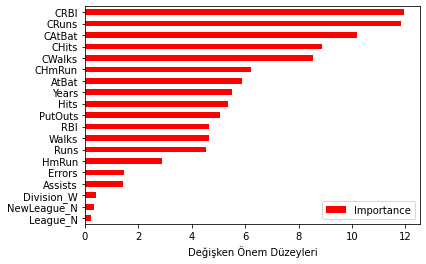

In [173]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri");

#### Yapısı bilinen bi veri setinde etkisi az olan değişkenler çıkartılabilir ya da çaprazlanabilir. Grafik incelenerek aksiyonlar alınabilir.

# Gradient Boosting Machines
## AdaBoost'un sınıflandırma ve regresyon problemlerine kolayca uygulanabilen genelleştirilmiş versiyonudur.

#### Adaptive Boosting (AdaBoost) Zayıf öğrenicileri birlşetirip güçlü bir öğrenici oluşturulmasını bulan algotritma. Dez avantajı tek bir cost fonksiyonu olmasıdır. GBM ile uygun bir cost fonksiyonu üzerinde çalışan optimizasyon algoritmasına dönüşmüş oluyor ağaca dayalı bu yöntem GBM.
# ---------------------------------------------------------------------------
### Gradient boosting tek bir tahminsel model formunda olan modeller serisi oluşturur.
### Seri içersiindeki bir model serideki bir önceki modelin tahmin artıklarının/hatalarının(residuals) üzerine kurularak (fit) oluşturulur.
### GBM diferansiyellenebilen herhangi bir kayıp fonksiyonunu optimize edebilen Gradient descent algoritmasını kullanmakta.
### GB bir çok temel öğrenici tipi(base learner type) kullanabilir.(Trees, linear terms, splines,..)
### cost fonksiyonları ve link fonksiyonları modifiye edilebilirdir.
### Boosting + Gradient Descent olarak da bilinir.

In [174]:
from sklearn.ensemble import GradientBoostingRegressor

In [175]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor()

## Tahmin

In [176]:
y_pred = gbm_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

350.1430669536858

## Model Tuning

In [177]:
gbm_params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 8,50,100],
    'n_estimators': [200, 500, 1000, 2000],
    'subsample': [1,0.5,0.75],
}

In [178]:
gbm = GradientBoostingRegressor()
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2) # verbose=2 iterasyonları gözlemleme ilgili bir argüman 
gbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 23.8min finished


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 8, 50, 100],
                         'n_estimators': [200, 500, 1000, 2000],
                         'subsample': [1, 0.5, 0.75]},
             verbose=2)

In [179]:
gbm_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}

In [180]:
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.1,  
                                      max_depth = 5, 
                                      n_estimators = 200, 
                                      subsample = 0.5)

gbm_tuned = gbm_tuned.fit(X_train,y_train)

In [181]:
y_pred = gbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

347.6303519000452

In [182]:
Importance = pd.DataFrame({"Importance": gbm_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

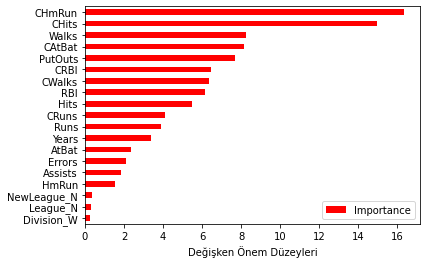

In [183]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

# XGBoost

### (eXtreme Gradient Boosting) XGBoost, GBM'in hız ve tahmin performansını arttırmak üzere optimize edilmiş, ölçeklenebilir ve farklı platformlara entegre edilebilir halidir.
#### Son zamanlarda lightboost daha başarılı xgboost'un üzerine koyarak ilerlemiştir

# ---------------------------------------------------------------------------------------------------

### R,Python, Hadoop, Scala, Julia ile kullanılabilir
### Ölçeklenebilirdir
### Hızlıdır
### Tahmin başarısı yüksektir.
### Birçok kaggle yarışmasında başarısını kanıtlamıştır.

In [185]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [186]:
#!pip install xgboost

In [187]:
import xgboost as xgb
# Pandas dataframe yerine xgboostun kendi yapılarını kullanırsak aşağıdaki gibi daha iyi ve hızlı sonuç elde edebiliriz.

In [188]:
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)
#kendi fnksiyonlarını kullanarak tanımladık

In [189]:
from xgboost import XGBRegressor
#fonksiyonu çağırdık

In [190]:
xgb_model = XGBRegressor().fit(X_train, y_train)
#modeli oluşturduk. Ancak yukarda oluşturduğumuz yapıyı kullanmayıp eski yapıyı kullanmaya devam ettik model oluştururken.

## Tahmin

In [191]:
y_pred = xgb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

355.46515176059927

## Model Tuning

In [192]:
xgb_model
# booster="gbtree" yani ağaca dayalı bir model kullanıcaz
# colsample_bynode=1 yani  ağaç başına değişkenlerden alınacak olan örnek
# learning_rate yani öğrenme için daraltma adımı. Overfitting olayına karşın bunu dikkate alıyoruz. 0-1 aralığında değer alır. Çok küçük olması tahmin süresini uzatır ancak başarıyı uzatır. 
# max_depth=3 karmaşıklık parametresi oalrak adlandırılabilir öğrenme derinliği anlamına gelir.
# n_estimators değerini de deneyeceğiz

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [193]:
xgb_grid = {
     'colsample_bytree': [0.4, 0.5,0.6,0.9,1], 
     'n_estimators':[100, 200, 500, 1000],
     'max_depth': [2,3,4,5,6],
     'learning_rate': [0.1, 0.01, 0.5]
}


In [194]:
#metodumuzu çağırdık modelimizi oluşturduk ve fit ettik 3000 tane fit etme işlemi gerçekleştiricek. öncekinde 2400 parametre incelenmişti
xgb = XGBRegressor()

xgb_cv = GridSearchCV(xgb, 
                      param_grid = xgb_grid, 
                      cv = 10, 
                      n_jobs = -1,
                      verbose = 2)


xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 36.6min finished


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_par

In [208]:
xgb_cv.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 1000}

In [209]:
xgb_tuned = XGBRegressor(colsample_bytree = 0.9, 
                         learning_rate = 0.01, 
                         max_depth = 5, 
                         n_estimators = 1000) 

xgb_tuned = xgb_tuned.fit(X_train,y_train)
#tune edilmiş final modelini best_params'a göre oluşturduk. İlerleyen zamanlarda daha detaylı incelememiz gerekn yerlerde paramatrelerin 3'ünü sabit tutup dışarda kalan 1 parametreyi inceleriz. Bunu her parametre için
#sırayla yapmamız gerekir. Modelde kullandığımız parametreler aşağıdadır. Örneğin ilk üçü sabit tutup learning_rate için sırayla 3 değeri deneyip optimumu bulabiliriz. Sırayla diğer parametlere için de tekrarlarız.
#     'colsample_bytree': [0.4, 0.5,0.6,0.9,1], 
#     'n_estimators':[100, 200, 500, 1000],
#     'max_depth': [2,3,4,5,6],
#     'learning_rate': [0.1, 0.01, 0.5]

In [210]:
y_pred = xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

366.8356053427891

# Light GBM

### Light GBM,XGBoost'un eğitim süresi performansını arttırmaya yönelik geliştirilen bir diğer GBM türüdür.

# -----------------------------------------------------------------------------------------------------

### Daha performanslıdır 
### Level-wise büyüme stratejisi yerine Leaf-wise büyüme stratejisini kullanır
### Breadth-first searh(BFS) yerine depth-first search(DFS) kullanılır


#### split etme işlemleri:
#### **Level-wise: XGboost değişkenleri ayırmak ve farklı bölüm noktalarını keşfetmek için karar ağaçlarını kullanıyor.**
#### **Leaf-wise: LightGBM ise daha iyi fit edebilmek için splitlere odaklanır.**
#### **XGBoost daha geniş kapsamlı bir ilk arama yapar Light GBM ise daha derinlemesine bir ilk arama yapar.

In [10]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [11]:
#!pip install lightgbm

In [12]:
from lightgbm import LGBMRegressor

In [13]:
#conda install -c conda-forge lightgbm
#pipisntall ile kurulum olmazsa conda ile yükleme yapabilirz. Bazen LGBMRegressor modülünü alırken image not found şeklinde hata verebiliyor.

In [14]:
from lightgbm import LGBMRegressor

In [15]:
lgbm = LGBMRegressor()
lgbm_model = lgbm.fit(X_train, y_train)
#modelimizi kurduk

## Tahmin

In [16]:
y_pred = lgbm_model.predict(X_test, 
                            num_iteration = lgbm_model.best_iteration_)
#num_iteration=lgbm_model.best_iteration_ kullanarak tahmin modelimizi oluşturduk

In [17]:
np.sqrt(mean_squared_error(y_test, y_pred))

363.8712087611089

## Model Tuning

In [20]:
!lgbm_model

/bin/bash: lgbm_model: komut yok


In [202]:
lgbm_grid = {
    'colsample_bytree': [0.4, 0.5,0.6,0.9,1],
    'learning_rate': [0.01, 0.1, 0.5,1],
    'n_estimators': [20, 40, 100, 200, 500,1000],
    'max_depth': [1,2,3,4,5,6,7,8] }

lgbm = LGBMRegressor()
lgbm_cv_model = GridSearchCV(lgbm, lgbm_grid, cv=10, n_jobs = -1, verbose = 2)

In [203]:
lgbm_cv_model.fit(X_train, y_train)
#XGBM ile önceki işlem 3000 fitte 36 dk sürdü. Light GBM ile 9000 fit etme 5 dk sürdü

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 7474 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 8688 tasks      | elapsed:  4.6min


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed:  5.2min finished


GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6, 0.9, 1],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [20, 40, 100, 200, 500, 1000]},
             verbose=2)

In [204]:
lgbm_cv_model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 20}

In [205]:
lgbm_tuned = LGBMRegressor(learning_rate = 0.1, 
                           max_depth = 7, 
                           n_estimators = 40,
                          colsample_bytree = 0.6)

lgbm_tuned = lgbm_tuned.fit(X_train,y_train)
#gelen best_params'a göre final modelini tune edilmiş modelimizi oluşturduk. Aşağıda a sonuçlarımızı elde ettik.

In [206]:
y_pred = lgbm_tuned.predict(X_test)

In [207]:
np.sqrt(mean_squared_error(y_test, y_pred))

#XGBMde 366 çıktı LGBM'de 372 çıktı değer olarak daha iyi olmasa da zaman olarak 7de biri.

372.7342551250238

# CatBoost (Category Boosting)

### Kategorik değişkenlerle otomatik olarak mücadele edebilen,hızlı,başarılı bir diğer GBM türevi.

# --------------------------------------------------------------------------------------------

### Kategorik değişken desteği
### Hızlı ve ölçeklenebilir GPU desteği
### Daha başarılı tahminler
### Hızlı train ve hızlı tahmin
### Rusyanın ilk açık kaynak kodlu, başarılı ML çalışmasıdır.

In [ ]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [211]:
!pip install catboost

     |████████████████████████████████| 65.7 MB 44 kB/s  eta 0:00:01    |█                               | 2.0 MB 2.5 MB/s eta 0:00:26     |█████▌                          | 11.4 MB 2.8 MB/s eta 0:00:20     |████████████████▌               | 34.0 MB 2.2 MB/s eta 0:00:15     |█████████████████████▌          | 44.1 MB 3.8 MB/s eta 0:00:06     |████████████████████████▌       | 50.2 MB 2.8 MB/s eta 0:00:06
     |████████████████████████████████| 13.2 MB 2.5 MB/s eta 0:00:01     |███████████████████████████▏    | 11.2 MB 2.6 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=f93eb5566cb3a74cd27a645448227348fda14f44f365ed6612d80419a306944c
  Stored in directory: /home/eren/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [212]:
from catboost import CatBoostRegressor

In [213]:
catb = CatBoostRegressor()
catb_model = catb.fit(X_train, y_train)
#parametre girmeden model kurm aişlemi gerçekleştirildi. Çalışma dizinine catboost_info adlı klasör oluşturuldu

Learning rate set to 0.029229
0:	learn: 438.1974206	total: 51.9ms	remaining: 51.9s
1:	learn: 432.4168868	total: 59.4ms	remaining: 29.6s
2:	learn: 426.3836690	total: 61.4ms	remaining: 20.4s
3:	learn: 420.2261014	total: 63.4ms	remaining: 15.8s
4:	learn: 414.9976675	total: 65.5ms	remaining: 13s
5:	learn: 409.6125323	total: 68.5ms	remaining: 11.3s
6:	learn: 403.9277911	total: 73.5ms	remaining: 10.4s
7:	learn: 398.4395285	total: 77.6ms	remaining: 9.62s
8:	learn: 392.4517081	total: 82.1ms	remaining: 9.04s
9:	learn: 387.4871123	total: 88.3ms	remaining: 8.74s
10:	learn: 382.6230510	total: 93.6ms	remaining: 8.41s
11:	learn: 378.1012454	total: 96.7ms	remaining: 7.96s
12:	learn: 372.6002306	total: 102ms	remaining: 7.74s
13:	learn: 368.4682192	total: 105ms	remaining: 7.41s
14:	learn: 364.0565766	total: 109ms	remaining: 7.13s
15:	learn: 359.5683249	total: 112ms	remaining: 6.9s
16:	learn: 355.1782794	total: 115ms	remaining: 6.66s
17:	learn: 350.4689946	total: 119ms	remaining: 6.47s
18:	learn: 346.25

## Tahmin

In [214]:
y_pred = catb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))
#ilkel test performansı

350.2683163098795

## Model Tuning

In [216]:
catb_grid = {
    'iterations': [200,500,1000,2000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [3,4,5,6,7,8] }

#grid oluştururken parametreleri giriyoruz devamında en iyisini bulup final tune edilmiş modelimizi oluşturup değerleri inceleyeceğiz.

In [217]:
catb = CatBoostRegressor()
catb_cv_model = GridSearchCV(catb, catb_grid, cv=5, n_jobs = -1, verbose = 2)

In [218]:
catb_cv_model.fit(X_train, y_train)
#zamanı normal bilgisayarda 45 dk sürdü burda çalıştırmadım. Performans olarak kötü bir yöntem. Ruslar veYandex sağolsun......

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.0s


KeyboardInterrupt: 

In [ ]:
catb_cv_model.best_params_

In [ ]:
catb_tuned = CatBoostRegressor(iterations = 200, 
                               learning_rate = 0.01, 
                               depth = 8)

catb_tuned = catb_tuned.fit(X_train,y_train)

In [ ]:
y_pred = catb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))